In [ ]:
import numpy as np 
import matplotlib.pyplot as plt 
import glob
from astropy.io import fits
from astropy.wcs import WCS
from astropy.visualization import ZScaleInterval
import glob
import pandas as pd
from astropy.visualization import imshow_norm, MinMaxInterval, SqrtStretch,PercentileInterval,ImageNormalize,PowerStretch,LogStretch
import cmasher as cmr
from matplotlib.patches import Rectangle

In [ ]:
import os
import wget
def get_uvot(observation_id, segment, uvfilter):
    url = f"https://www.swift.ac.uk/archive/reproc/000{observation_id}00{segment}/uvot/image" 
    filename = f"/sw000{observation_id}00{segment}{uvfilter}_sk" 
    ext = ".img.gz"
    download = url+filename+ext
    save = f'../SUMS/tmp/{observation_id}_{segment}_{uvfilter}.fits'
    try:
        if os.path.exists(save):
            os.remove(save) # if exist, remove it directly
        wget.download(download,out=save)
        hdu = fits.open(save)
        return hdu
    except:
        print('Could not download file')
        print(download)
        return None

In [3]:
# What image has the longest exposure time?

dir = "H:/Data/SUMS_Tractor_Data/smc"

files = glob.glob(f'{dir}/smc*/*/*1_img*')
exposures = []
for f in files: 
    # Get header
    hdu = fits.open(f)[0]
    exp = hdu.header['EXPOSURE']
    exposures.append(exp)
# Make dataframe 
exposures = np.array(exposures)
df = pd.DataFrame({'file':files,'exposure':exposures})
df

,file,exposure
0,H:/Data/SUMS_Tractor_Data/smc\smc_4041X\sw0004...,190.714999
1,H:/Data/SUMS_Tractor_Data/smc\smc_4041X\sw0004...,194.602483
2,H:/Data/SUMS_Tractor_Data/smc\smc_4041X\sw0004...,190.714999
3,H:/Data/SUMS_Tractor_Data/smc\smc_4041X\sw0004...,230.078528
4,H:/Data/SUMS_Tractor_Data/smc\smc_4041X\sw0004...,221.087330
...,...,...
298,H:/Data/SUMS_Tractor_Data/smc\smc_4046X\sw0004...,447.408744
299,H:/Data/SUMS_Tractor_Data/smc\smc_4046X\sw0004...,446.605161
300,H:/Data/SUMS_Tractor_Data/smc\smc_4046X\sw0004...,485.979556
301,H:/Data/SUMS_Tractor_Data/smc\smc_4046X\sw0004...,435.214159


In [4]:
def get_data(folder):
    image_hdu = fits.open(glob.glob(f'{folder}*1_img.fits')[0])[0]
    model_hdu =  fits.open(glob.glob(f'{folder}*model.fits')[0])[0]
    bkgrd_hdu = fits.open(glob.glob(f'{folder}*bkgd*_img.fits')[0])[0]
    chi_hdu = fits.open(glob.glob(f'{folder}*chi.fits')[0])[0]
    # Not the background itself but the background subtracted image
    bkgrd = bkgrd_hdu.data
    image = image_hdu.data 
    model = model_hdu.data 
    wcs = WCS(image_hdu)
    return bkgrd,model,wcs
def plot(image,model,xdim,ydim):
    resid = image - model
    # Create an ImageNormalize object
    i = np.copy(image)[ydim[0]:ydim[1],xdim[0]:xdim[1]]
    interval = ZScaleInterval()
    norm = ImageNormalize(i, interval=interval)
    # freeze and cosmic are also pretty
    cmap = 'bone'

    fig = plt.figure(figsize=(16,8))
    ax = plt.subplot(131)
    bx = plt.subplot(132)
    cx = plt.subplot(133)
    axes = [ax,bx,cx]

    ax.imshow(image, cmap=cmap, origin='lower', norm=norm)
    bx.imshow(model, cmap=cmap, origin='lower', norm=norm,)
    cax = cx.imshow(resid, cmap=cmap, origin='lower', norm=norm)
    axes = [ax,bx,cx]
    # colorbar
    plt.colorbar(cax, ax=axes, orientation='vertical',fraction=0.0167,pad=0.04)
    #plt.colorbar(d,fraction=0.046, pad=0.04)
    [ax.set_xlim(xdim) for ax in axes]
    [ax.set_ylim(ydim) for ax in axes]


H:/Data/SUMS_Tractor_Data/smc\smc_4041X\sw00040418001um2_sk_40418_1_1\40418_um2_1_1_img.fits


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
Set MJD-OBS to 55467.665729 from DATE-OBS.
Set MJD-END to 55467.671678 from DATE-END'. [astropy.wcs.wcs]


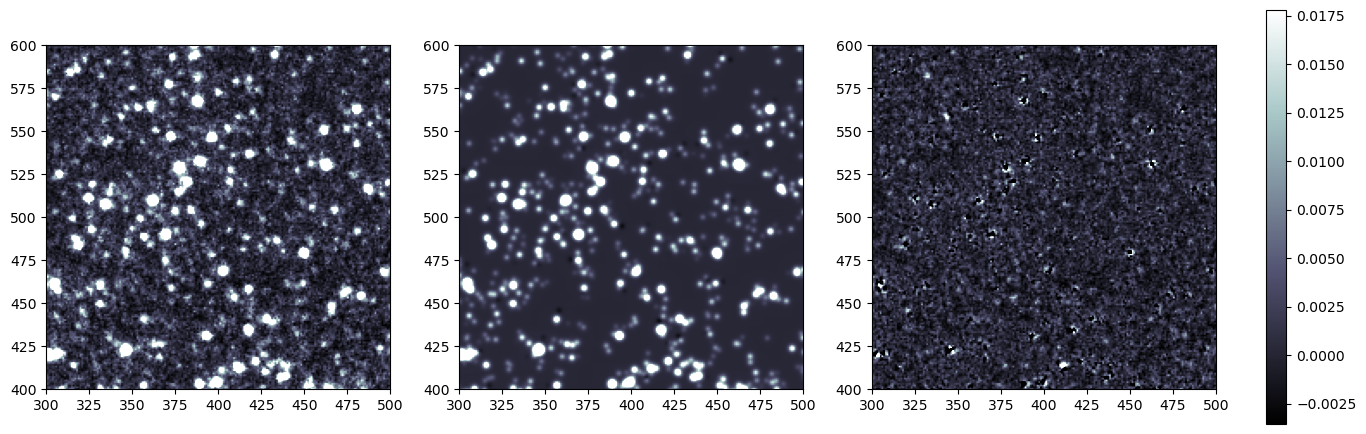

In [5]:
file = df.loc[df.exposure>500,'file'].values[0]
print(file)
path = file.split('\\')[:-1]
image,model,wcs = get_data('/'.join(path)+'/')
yw = 0
xw = -300
plot(image,model,[600+xw,800+xw],[400+yw,600+yw])

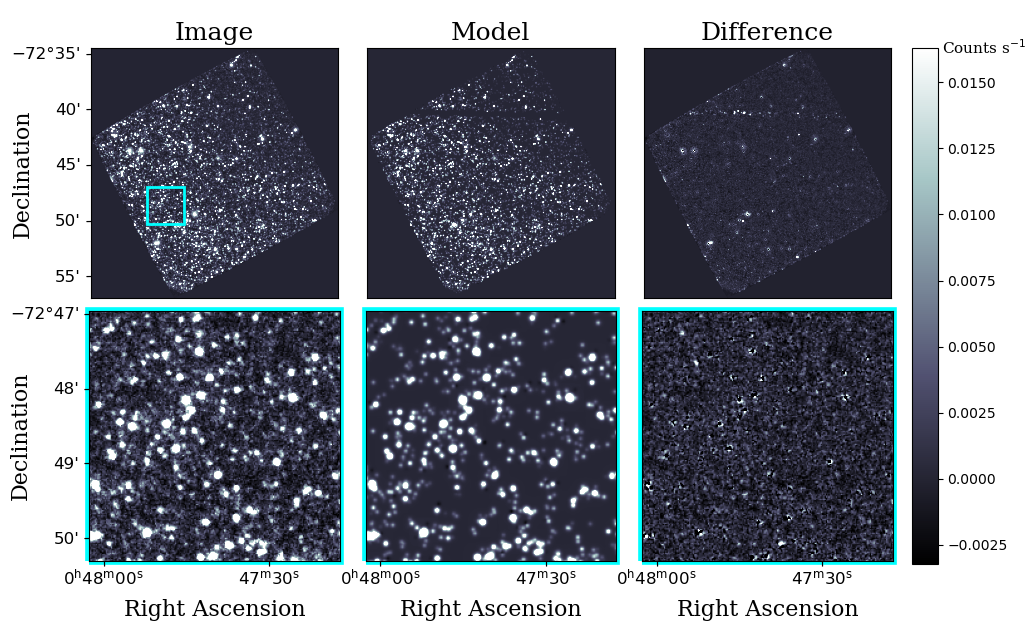

In [ ]:
# Make a nice plot now
fig = plt.figure(figsize=(11,10*2/3))
ax = plt.subplot(231, projection=wcs)
bx = plt.subplot(232, projection=wcs)
cx = plt.subplot(233, projection=wcs)
axes = [ax,bx,cx]
# Cmap 
cmap = 'bone'
# Font
font = {'family': 'serif',
        'font':'cmr10',
        'size': 16}
# Scaling 
xdim = [300,1000]
ydim = [300,1000]
i = np.copy(image)[ydim[0]:ydim[1],xdim[0]:xdim[1]]
interval = ZScaleInterval()
norm = ImageNormalize(i, interval=interval)
# Plot 1: Image 
ax.imshow(image, cmap=cmap, origin='lower', norm=norm)
# Plot 2: Model
bx.imshow(model, cmap=cmap, origin='lower', norm=norm)
# Plot 3: Residuals
c_im = cx.imshow(image-model, cmap=cmap, origin='lower', norm=norm)
# Make a box on the first plot 
xdim = [300,400+100]
ydim = [400,500+100]
boxcolor = 'cyan'
ax.add_patch(Rectangle((xdim[0] - .5, ydim[0] - .5), xdim[1]-xdim[0], ydim[1]-ydim[0], facecolor="none", ec=boxcolor, lw=2))
# Second row 
dx = plt.subplot(234, projection=wcs)
ex = plt.subplot(235, projection=wcs)
fx = plt.subplot(236, projection=wcs)
axes = [dx,ex,fx]
# Set xlabel
[ax.set_xlabel('Right Ascension',fontdict=font) for ax in axes]
# Set ylabel
[ax.set_ylabel('Declination',fontdict=font,labelpad=-0.5) for ax in [ax,dx]]
# Plot 1: Image 
dx.imshow(image, cmap=cmap, origin='lower', norm=norm)
# Plot 2: Model
ex.imshow(model, cmap=cmap, origin='lower', norm=norm)
# Plot 3: Residuals
c_im = fx.imshow(image-model, cmap=cmap, origin='lower', norm=norm)
# Set limits
[ax.set_xlim(xdim) for ax in axes]
[ax.set_ylim(ydim) for ax in axes]
# Take yticks off of the second two columns
for ax_i in [bx,cx,ex,fx]:
    ax_i.coords[1].set_ticks_visible(False)
    ax_i.coords[1].set_ticklabel_visible(False)   
# Have minor ticks only on bottom and left for y 
for ax_i in [ax,dx]:
    ax_i.coords[1].set_ticks_position('bl')
for ax_i in [ax,bx,cx]:
    # Remove plot label from top row 
    ax_i.coords[0].set_ticklabel_visible(False) 
    ax_i.coords[0].set_ticks_visible(False) 
for ax_i in [ax,bx,cx,dx,ex,fx]:
    # Set coordinate tick format
    ax_i.coords[0].set_major_formatter('hh:mm:ss')
    ax_i.coords[1].set_major_formatter('dd:mm')
    # Have minor ticks only on bottom for x
    ax_i.coords[0].set_ticks_position('b')
    # Set tick font
    ax_i.tick_params(axis='both', which='major', labelsize=12,fontdict=font)
for ax_i in [dx,ex,fx]:
    # Outline the box
    ax_i.patch.set_edgecolor('cyan')  
    ax_i.patch.set_linewidth(5.5) 

    # Try to space out the ticks
    n=3
    ax_i.coords[0].set_ticks(number=n-1)
    ax_i.coords[1].set_ticks(number=n)
# Colorbar axis 
c_ax = dx.inset_axes([3.27, -0.01, 0.3, 2.212]) # [x0, y0, width, height]
# Remove axis border
c_ax.set_xticks([])
c_ax.set_yticks([])
[c_ax.spines[dir].set_visible(False) for dir in ['top','left','bottom','right']]
# Colorbar plot
frac = 1
plt.colorbar(c_im, ax=c_ax, orientation='vertical',fraction=frac)
# Colorbar title 
c_ax.text(0.45,0.92, 'Counts s$^{-1}$', size=11, transform=c_ax.transAxes,fontdict=font)

# Move suplots closer together
fig.subplots_adjust(wspace=-0.22,hspace=0.05)
# Make face of plot white
fig.patch.set_facecolor('white')
# Titles
titlesize = 16+2
ax.set_title('Image',fontdict=font,size=titlesize)
bx.set_title('Model',fontdict=font,size=titlesize)
cx.set_title('Difference',fontdict=font,size=titlesize)

# Save the figure
# This cuts off the figure but you can save in vscode 
# Higher numbers moves it to the right 
fig.subplots_adjust(left=0.075) 
plt.savefig('tractor_example.pdf')